<a href="https://colab.research.google.com/github/orinizri/ML_AI_colab_notebooks/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip3 install torch
# !pip3 install torchvision

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:04<00:00, 2231501.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 515186.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4038309.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4943053.65it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def image_convert(tensor):
    # Clone the tensor and detach it from the computation graph to avoid affecting gradients
    image = tensor.cpu().clone().detach().numpy()
    # Transpose from (C, H, W) to (H, W, C) to match standard image format
    image = image.transpose(1, 2, 0)
    # Denormalize the image (assuming it was normalized with mean=0.5 and std=0.5)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    # Clip values to ensure they're between 0 and 1, as required for images
    image = np.clip(image, 0, 1)
    return image


In [ ]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

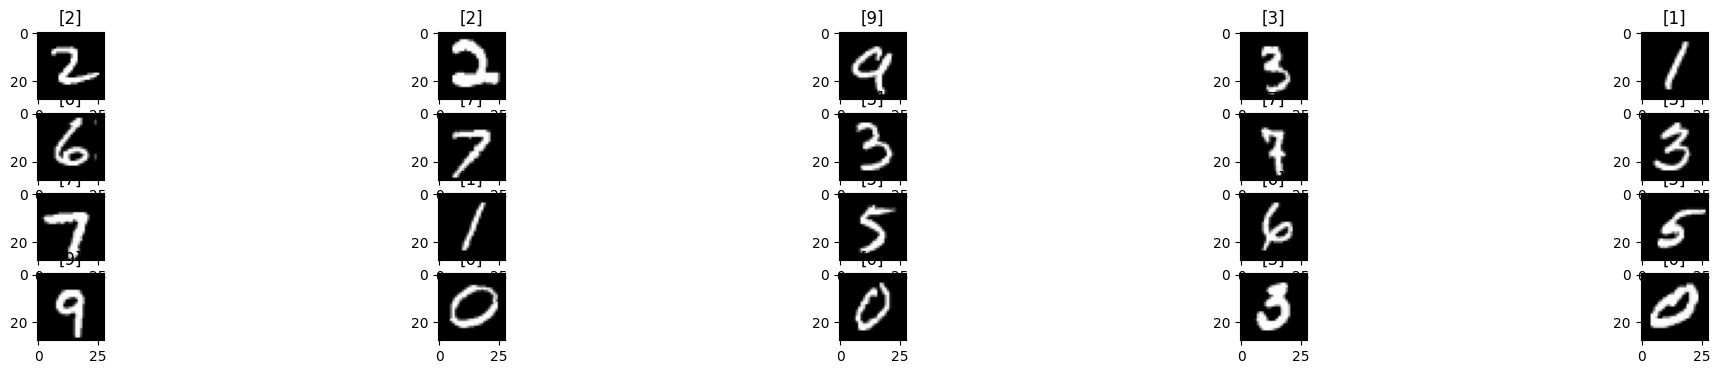

In [ ]:
data_iterator = iter(training_loader)
images, labels = next(data_iterator)
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
  ax = fig.add_subplot(4, 5, i + 1)
  plt.imshow(image_convert(images[i]))
  ax.set_title([labels[i].item()])


In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    # in_channel, features, kernel size, stride
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(800, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 800)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 12
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, labels)
          _, val_preds = torch.max(outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == labels.data)



    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch:', e + 1)
    print('training loss: {:.4f}, accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


epoch: 1
training loss: 0.5720, accuracy: 84.8600
validation loss: 7.8039, accuracy: 94.0000
epoch: 2
training loss: 0.1484, accuracy: 95.6400
validation loss: 9.4435, accuracy: 100.0000
epoch: 3
training loss: 0.0968, accuracy: 97.1400
validation loss: 10.2649, accuracy: 96.0000
epoch: 4
training loss: 0.0761, accuracy: 97.6933
validation loss: 10.6450, accuracy: 96.0000
epoch: 5
training loss: 0.0624, accuracy: 98.0967
validation loss: 11.6570, accuracy: 98.0000
epoch: 6
training loss: 0.0541, accuracy: 98.3867
validation loss: 11.9605, accuracy: 99.0000
epoch: 7
training loss: 0.0478, accuracy: 98.5550
validation loss: 12.4017, accuracy: 99.0000
epoch: 8
training loss: 0.0420, accuracy: 98.7150
validation loss: 12.8957, accuracy: 96.0000
epoch: 9
training loss: 0.0399, accuracy: 98.7800
validation loss: 13.1012, accuracy: 100.0000
epoch: 10
training loss: 0.0356, accuracy: 98.9150
validation loss: 13.8087, accuracy: 99.0000
epoch: 11
training loss: 0.0330, accuracy: 98.9850
validati

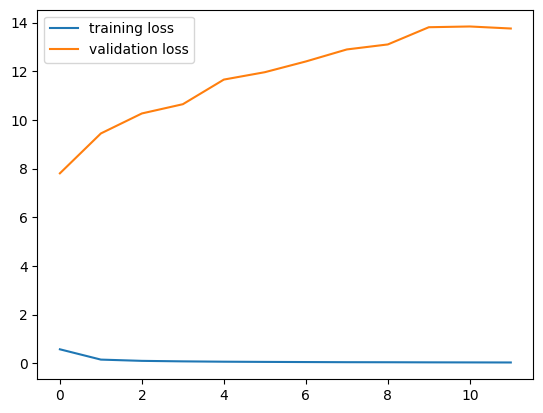

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
running_corrects_history_Cpu = torch._to_cpu(running_corrects_history)
plt.plot(running_corrects_history, label='training corrects')
plt.plot(val_running_corrects_history, label='validation corrects')
plt.legend()

NameError: name 'torch' is not defined

In [ ]:
import requests
from PIL import Image
import PIL

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [ ]:
# Preprocess black background and white number
img = PIL.ImageOps.invert(img)
# black and white
img = img.convert('1')
img = transform(img)
plt.imshow(image_convert(img))

In [ ]:
images = img.to(device)
images = images[0].unsqueeze(0).unsqueeze(0)
output = model(images)
_, pred = torch.max(output, 1)
pred.item()

In [ ]:
data_iterator = iter(validation_loader)
images, labels = next(data_iterator)
images = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(25,4))
outputs = model(images)
_, preds = torch.max(outputs, 1)
for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i + 1)
  plt.imshow(image_convert(images[i]))
  ax.set_title('{} ({})'.format(str(preds[i].item()), str(labels[i].item())), color=("green" if preds[i] == labels[i] else "red"))